### LSTM - Input: 'Close/Last', 'COMP', 'NATS', 'MSCI'

In [10]:
import pandas as pd

# Load the data
data = pd.read_csv('Data_input_3.csv')

# Check for missing values
print(data.isnull().sum())

# Fill missing values or drop rows with missing values
data.fillna(method='ffill', inplace=True)  # forward fill
data.dropna(inplace=True)  # drop any remaining NaNs


Date          0
Close/Last    0
COMP          0
NATS          0
MSCI          0
dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_1468\1134100619.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # forward fill


In [11]:
data['Date'] = pd.to_datetime(data['Date'])

# Tạo các cột phụ để sắp xếp theo năm, tháng, ngày
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Sắp xếp DataFrame theo năm, sau đó tháng, và cuối cùng là ngày
data.sort_values(['Year', 'Month', 'Day'], inplace=True)

# Xóa các cột phụ nếu không cần thiết
data.drop(columns=['Year', 'Month', 'Day'], inplace=True)
data

,Date,Close/Last,COMP,NATS,MSCI
1257,2019-06-03,4170.02,7333.02,835.84,2615.02
1256,2019-06-04,4320.98,7527.12,863.30,2671.61
1255,2019-06-05,4329.21,7575.48,875.85,2693.60
1254,2019-06-06,4375.45,7615.55,881.34,2709.88
1253,2019-06-07,4435.80,7742.10,894.46,2738.40
...,...,...,...,...,...
4,2024-05-23,10495.82,16736.03,1770.08,5016.81
3,2024-05-24,10549.22,16920.79,1751.27,5051.83
2,2024-05-28,10526.85,17019.88,1739.75,5051.64
1,2024-05-29,10396.40,16920.58,1733.33,5014.18


In [12]:
import numpy as np

# Tính toán số lượng dòng cho từng phần
total_rows = len(data)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)
test_size = total_rows - train_size - val_size  # Đảm bảo rằng tổng số dòng vẫn bằng total_rows

# Xử lý các giá trị vô hạn hoặc quá lớn
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(how='any', axis=0, inplace=True)

# Chia DataFrame thành các tập huấn luyện, kiểm tra và kiểm định
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size + val_size]
data_test = data.iloc[train_size + val_size:]

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa các cột giá dựa trên tập huấn luyện và áp dụng cho tập kiểm tra và kiểm định
scaler_price = MinMaxScaler(feature_range=(-1, 1))
price_columns = ['Close/Last', 'COMP', 'NATS', 'MSCI']
data_train_copy=data_train[price_columns]
data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
data_val[price_columns] = scaler_price.transform(data_val[price_columns])
data_test_copy=data_test[price_columns]
data_test[price_columns] = scaler_price.transform(data_test[price_columns])

# Chuyển đổi các cột pandas thành mảng NumPy
train_data = data_train[price_columns].values
val_data = data_val[price_columns].values
test_data = data_test[price_columns].values

# Hiển thị kích thước của các tập dữ liệu
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (1006, 4)
Validation data shape: (125, 4)
Test data shape: (127, 4)


C:\Users\DELL\AppData\Local\Temp\ipykernel_1468\3631155638.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
C:\Users\DELL\AppData\Local\Temp\ipykernel_1468\3631155638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val[price_columns] = scaler_price.transform(data_val[price_columns])
C:\Users\DELL\AppData\Local\Temp\ipykernel_1468\3631155638.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [14]:
# Training data
seq_len = 30
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 0][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (976, 30, 4) (976,)
Validation set shape (95, 30, 4) (95,)
Testing set shape (97, 30, 4) (97,)


In [15]:
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.models import Sequential

model = Sequential([
    LSTM(2**6),
    Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predicting and reversing normalization
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_price.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 3))), axis=1))[:,0]

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1170 - val_loss: 0.0134
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0096 - val_loss: 0.0085
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

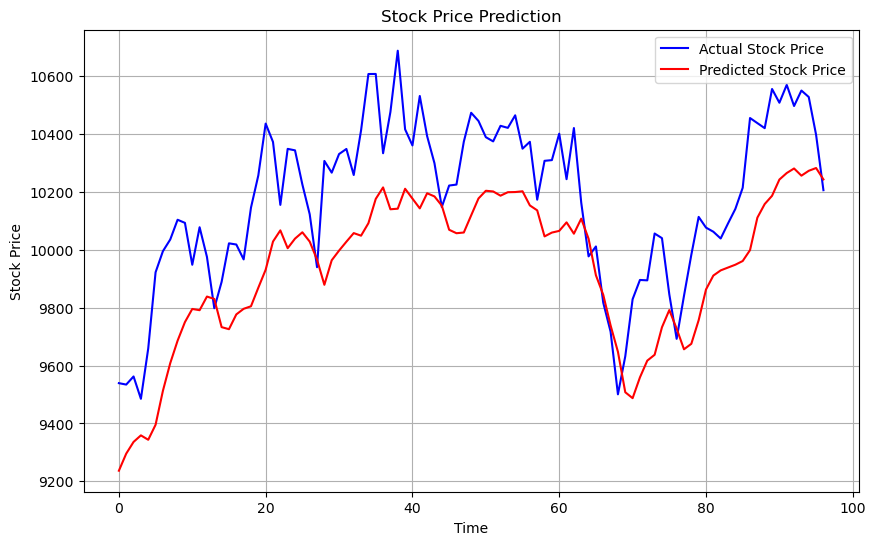

Root Mean Squared Error: 275.8136783730369
Mean Absolute Percentage Error: 0.02389559154224537


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test_copy['Close/Last'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


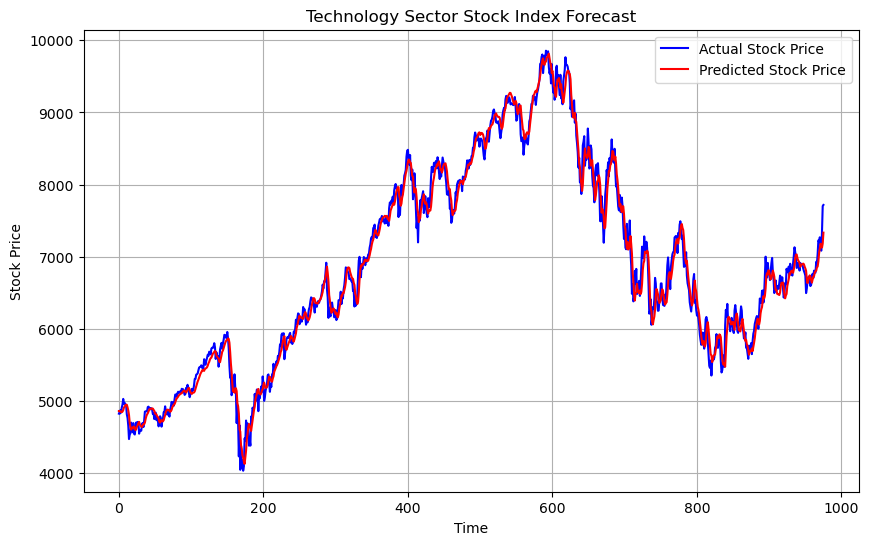

In [17]:
predicted_stock_price_train = model.predict(X_train)
predicted_stock_price_train = scaler_price.inverse_transform(np.concatenate((predicted_stock_price_train, np.zeros((len(predicted_stock_price_train), 3))), axis=1))[:,0]
actual_train_prices = data_train_copy['Close/Last'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_train_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price_train, color='red', label='Predicted Stock Price')
plt.title('Technology Sector Stock Index Forecast')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
model.save('1_layerLSTMEconomic.h5')
import joblib
joblib.dump(scaler_price, 'scaler_price_economic1lstm.pkl')
np.save('X_test_economic1ltsm.npy', X_test)